# Analysis of Generated DNF data
This notebook collects and analyses experiment results that are run on the generated DNF dataset.

In [1]:
# Collect imports
from typing import Dict
from pprint import pprint
import json

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
from mlflow.tracking import MlflowClient

import utils.analysis
import utils.clingo

np.set_printoptions(suppress=True, precision=5, linewidth=120)

In [2]:
# Setup mlflow client
mlclient = MlflowClient(tracking_uri="http://localhost:8888") # Emptry string for local
exp_list = [x.name for x in mlclient.list_experiments()]
print(exp_list)

['gendnf-ilp-20210421-173228', 'gendnf-deep-20210421-173228', '20210422-113459', '20210422-113929', 'gendnf-deep-20210422-122437', '20210422-173454', '20210422-175209', '20210422-180210', '20210422-185306', '20210422-185357', 'gendnf-deep-20210422-185525', '20210423-145146', 'gendnf-deep-20210423-150828']


## Aggregate Experiment Results
We will look at aggregate metric performances of runs in a given experiment.

- Compare best run for rule learning with symbolic learners.
- Show training curves

In [3]:
# Explore experiment and run data
experiment_name = "gendnf-deep-20210423-150828"
#experiment_name = exp_list[-1]
mlexp = mlclient.get_experiment_by_name(experiment_name)
print(mlexp)

<Experiment: artifact_location='/homes/nuric/phd/pix2rule/data/artifacts/28', experiment_id='28', lifecycle_stage='active', name='gendnf-deep-20210423-150828', tags={}>


In [4]:
# Load experiment data, this includes metrics and parameters
exp_data = utils.analysis.collect_experiment_data(experiment_name, mlclient)
exp_data.columns

Index(['epoch', 'train_loss', 'train_acc', 'validation_loss', 'validation_acc',
       'test_loss', 'test_acc', 'time', 'train_dnf_layer/success_threshold',
       'run_id', 'config_json', 'relsgame_tasks', 'relsgame_train_size',
       'relsgame_validation_size', 'relsgame_test_size', 'relsgame_batch_size',
       'relsgame_output_type', 'relsgame_with_augmentation',
       'relsgame_noise_stddev', 'relsgame_rng_seed', 'gendnf_num_objects',
       'gendnf_num_nullary', 'gendnf_num_unary', 'gendnf_num_binary',
       'gendnf_num_variables', 'gendnf_num_conjuncts', 'gendnf_target_arity',
       'gendnf_gen_size', 'gendnf_train_size', 'gendnf_validation_size',
       'gendnf_test_size', 'gendnf_batch_size',
       'gendnf_label_noise_probability', 'gendnf_rng_seed',
       'gendnf_return_numpy', 'dataset_name',
       'dnf_image_classifier_image_layer_name',
       'dnf_image_classifier_image_hidden_size',
       'dnf_image_classifier_image_activation',
       'dnf_image_classifier_image

In [5]:
# For our differentiable rule learning, we have X runs per rule
# and there are R many rules (one for each seed) for each difficulty giving X*R*D many runs
df = exp_data[exp_data['train_type'] == 'deep'][['run_id', 'gendnf_difficulty', 'gendnf_label_noise_probability', 'gendnf_rng_seed', 'run_count']]
df.drop_duplicates(inplace=True)
df.set_index('run_id', inplace=True)
# We will collect the pruning information which contains the final results for each run
run_ids = df.index.values
def load_run_json(run_id: str, fname: str,):
    """Load a run artifact json with specified file name."""
    fpath = mlclient.download_artifacts(run_id, fname)
    with open(fpath) as jsonfile:
        run_json = json.load(jsonfile)
    run_json['run_id'] = run_id
    return run_json
run_jsons = [load_run_json(ridx, "pruning_info.json") for ridx in run_ids]
assert len(run_jsons) == df.index.size, "Not all runs have a output json."
run_df = pd.DataFrame(run_jsons)
run_df.set_index('run_id', inplace=True)
# Filter only needed columns
acc_or_loss_cols = [c for c in run_df.columns.values if 'acc' in c or 'loss' in c]
run_df = run_df[acc_or_loss_cols]
# Join parameters and output dataframes
df = df.join(run_df)
df
        

,gendnf_difficulty,gendnf_label_noise_probability,gendnf_rng_seed,run_count,dnf_layer.or_kernel.validation_preprune_loss,dnf_layer.or_kernel.validation_preprune_acc,dnf_layer.or_kernel.test_preprune_loss,dnf_layer.or_kernel.test_preprune_acc,dnf_layer.or_kernel.validation_pruned_loss,dnf_layer.or_kernel.validation_pruned_acc,...,dnf_layer.and_kernel.test_pruned_loss,dnf_layer.and_kernel.test_pruned_acc,dnf_layer.and_kernel.validation_threshold_loss,dnf_layer.and_kernel.validation_threshold_acc,dnf_layer.and_kernel.test_threshold_loss,dnf_layer.and_kernel.test_threshold_acc,dnf_layer.and_kernel.validation_threshold_pruned_loss,dnf_layer.and_kernel.validation_threshold_pruned_acc,dnf_layer.and_kernel.test_threshold_pruned_loss,dnf_layer.and_kernel.test_threshold_pruned_acc
run_id,,,,,,,,,,,,,,,,,,,,,
39bd4ad88b774248a9e3edbf6ed59364,easy,0.30,21,0,0.570933,0.786,0.575669,0.792,0.570933,0.786,...,3.002476,0.500,3.002476,0.500,3.002476,0.500,3.002476,0.500,3.002476,0.500
3f3ca2858b25483d9db21fa9cdb8c5fb,hard,0.30,5,0,0.694401,0.500,0.694401,0.500,3.002476,0.500,...,3.002476,0.500,3.002476,0.500,3.002476,0.500,3.002476,0.500,3.002476,0.500
e4d45fb24d1745b0b7650efd1bd307e2,easy,0.15,3,2,0.619223,0.622,0.604098,0.619,0.619223,0.622,...,2.044004,0.588,2.342453,0.610,2.162456,0.640,2.342453,0.610,2.162456,0.640
00b9cee31f604109937c425315a1b93b,easy,0.30,30,3,0.519516,0.729,0.503815,0.736,0.519516,0.729,...,1.845086,0.569,2.600441,0.567,2.588443,0.569,2.600441,0.567,2.588443,0.569
52be697be8654e8b8ea2c3cd53637346,hard,0.00,5,3,0.001237,1.000,0.001237,1.000,0.002213,1.000,...,0.086072,0.986,0.008047,0.999,0.086072,0.986,0.008047,0.999,0.086072,0.986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6f57c9fd21f0481abe9c7cf1b56356e3,hard,0.00,3,1,0.001238,1.000,0.004763,0.999,0.002091,1.000,...,0.082834,0.984,0.002062,1.000,0.044056,0.993,0.008062,0.999,0.092050,0.987
d7bc7ad7f6374e269032d8a5baa2195e,medium,0.30,3,3,0.253886,0.960,0.240921,0.971,0.253900,0.960,...,3.002476,0.500,3.002476,0.500,3.002476,0.500,3.002476,0.500,3.002476,0.500
1d53e585f5b342eeb7f86edcd79903f9,hard,0.00,30,3,0.364451,0.841,0.364451,0.841,0.956501,0.841,...,0.778661,0.841,0.944495,0.843,0.956498,0.841,0.998299,0.842,0.872286,0.855


In [6]:
# Since symbolic learners are deterministic and return the optimal result, we will take the best
# out of 5 runs for each rule in each difficulty, but just to ensure that the results are consistent
# let's look at the 5 runs for each rule first
df.groupby(['gendnf_difficulty', 'gendnf_label_noise_probability', 'gendnf_rng_seed'])['dnf_layer.or_kernel.test_preprune_acc'].describe()

count  \
gendnf_difficulty gendnf_label_noise_probability gendnf_rng_seed          
easy              0.0                            3                  5.0   
                                                 5                  5.0   
                                                 16                 5.0   
                                                 21                 5.0   
                                                 27                 5.0   
...                                                                 ...   
medium            0.3                            16                 5.0   
                                                 21                 5.0   
                                                 27                 5.0   
                                                 30                 5.0   
                                                 32                 5.0   

                                                                    mean  \
gendnf_difficulty gendnf_label_noise_probability gendnf_rng_seed           
easy              0.0                            3                0.9534   
                                                 5                0.9702   
                                                 16               1.0000   
                                                 21               0.9912   
                                                 27               1.0000   
...                                                                  ...   
medium            0.3                            16               0.5004   
                                                 21               0.5000   
                                                 27               0.9148   
                                                 30               0.9530   
                                                 32               0.5000   

                                                                       std  \
gendnf_difficulty gendnf_label_noise_probability gendnf_rng_seed             
easy              0.0                            3                0.004336   
                                                 5                0.066635   
                                                 16               0.000000   
                                                 21               0.019677   
                                                 27               0.000000   
...                                                                    ...   
medium            0.3                            16               0.000894   
                                                 21               0.000000   
                                                 27               0.060433   
                                                 30               0.056573   
                                                 32               0.000000   

                                                                    min  \
gendnf_difficulty gendnf_label_noise_probability gendnf_rng_seed          
easy              0.0                            3                0.946   
                                                 5                0.851   
                                                 16               1.000   
                                                 21               0.956   
                                                 27               1.000   
...                                                                 ...   
medium            0.3                            16               0.500   
                                                 21               0.500   
                                                 27               0.837   
                                                 30               0.853   
                                                 32               0.500   

                                                                    25%  \
gendnf_difficulty gendnf_label_nois

In [7]:
best_run_ids = df.groupby(['gendnf_difficulty', 'gendnf_label_noise_probability', 'gendnf_rng_seed'])['dnf_layer.or_kernel.validation_preprune_loss'].idxmin()
best_runs = df.loc[best_run_ids]
best_runs.iloc[0]

gendnf_difficulty                                            easy
gendnf_label_noise_probability                                0.0
gendnf_rng_seed                                                 3
run_count                                                       2
dnf_layer.or_kernel.validation_preprune_loss             0.116611
dnf_layer.or_kernel.validation_preprune_acc                 0.955
dnf_layer.or_kernel.test_preprune_loss                   0.116238
dnf_layer.or_kernel.test_preprune_acc                       0.956
dnf_layer.or_kernel.validation_pruned_loss               0.116611
dnf_layer.or_kernel.validation_pruned_acc                   0.955
dnf_layer.or_kernel.test_pruned_loss                     0.116238
dnf_layer.or_kernel.test_pruned_acc                         0.956
dnf_layer.or_kernel.validation_threshold_loss            0.292563
dnf_layer.or_kernel.validation_threshold_acc                0.942
dnf_layer.or_kernel.test_threshold_loss                  0.286547
dnf_layer.

(0.45, 1.05)

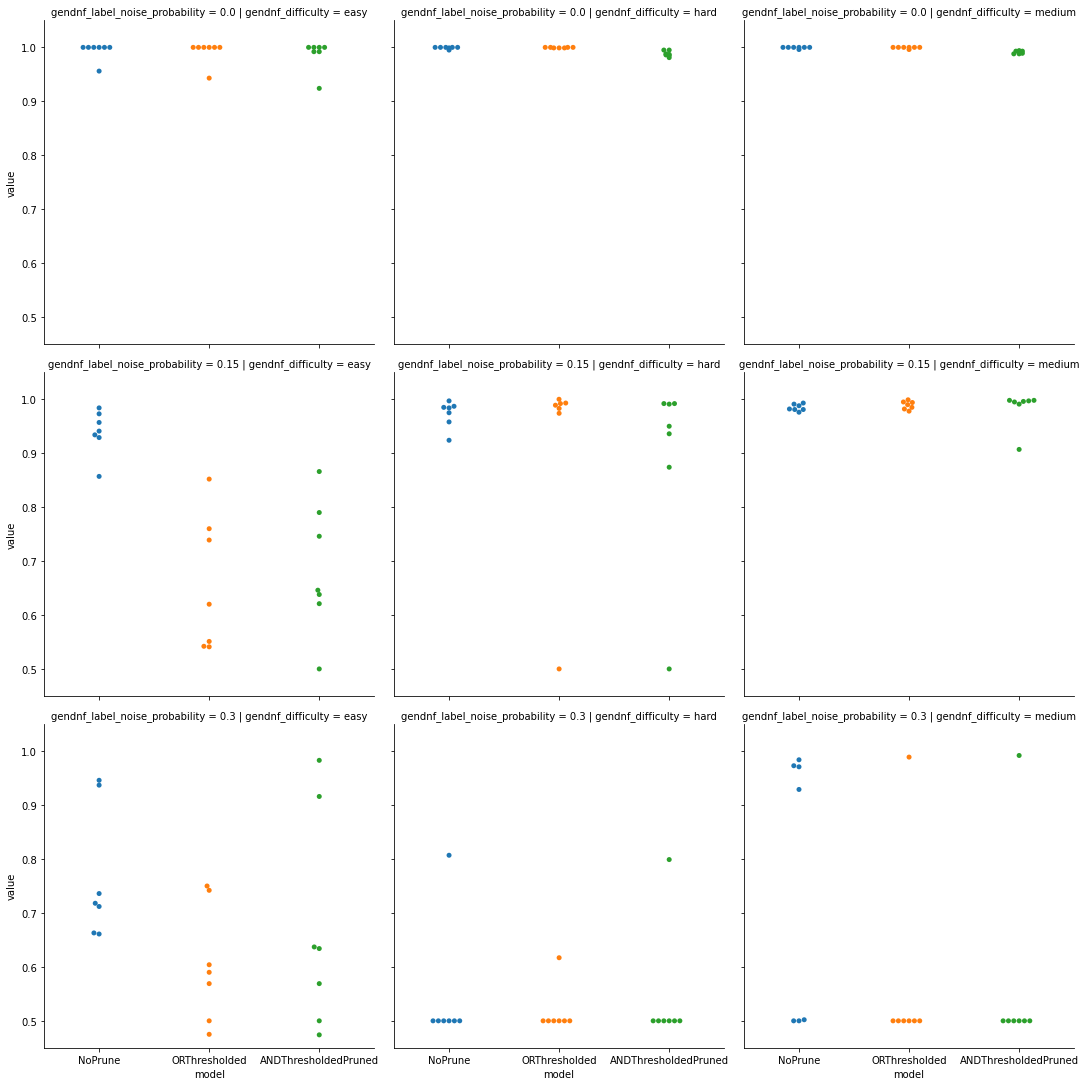

In [8]:
# Take the best run out of 5 based on validation loss
best_run_ids = df.groupby(['gendnf_difficulty', 'gendnf_label_noise_probability', 'gendnf_rng_seed'])['dnf_layer.or_kernel.validation_preprune_loss'].idxmin()
best_runs = df.loc[best_run_ids]
fields = ['dnf_layer.or_kernel.test_preprune_acc', 'dnf_layer.or_kernel.test_threshold_pruned_acc', 'dnf_layer.and_kernel.test_threshold_pruned_acc']
melted_runs = best_runs.melt(id_vars=['gendnf_difficulty', 'gendnf_label_noise_probability', 'gendnf_rng_seed'], value_vars=fields)
def get_model_name(acc_string: str):
    """Name models for clearer plots."""
    if acc_string == 'dnf_layer.or_kernel.test_preprune_acc':
        return 'NoPrune'
    if acc_string == 'dnf_layer.or_kernel.test_threshold_pruned_acc':
        return 'ORThresholded'
    if acc_string == 'dnf_layer.and_kernel.test_threshold_pruned_acc':
        return 'ANDThresholdedPruned'
melted_runs = melted_runs.assign(model=melted_runs['variable'].apply(get_model_name))
sns.catplot(x='model', y='value', col='gendnf_difficulty', row='gendnf_label_noise_probability', kind='swarm', data=melted_runs)
plt.ylim(0.45, 1.05)

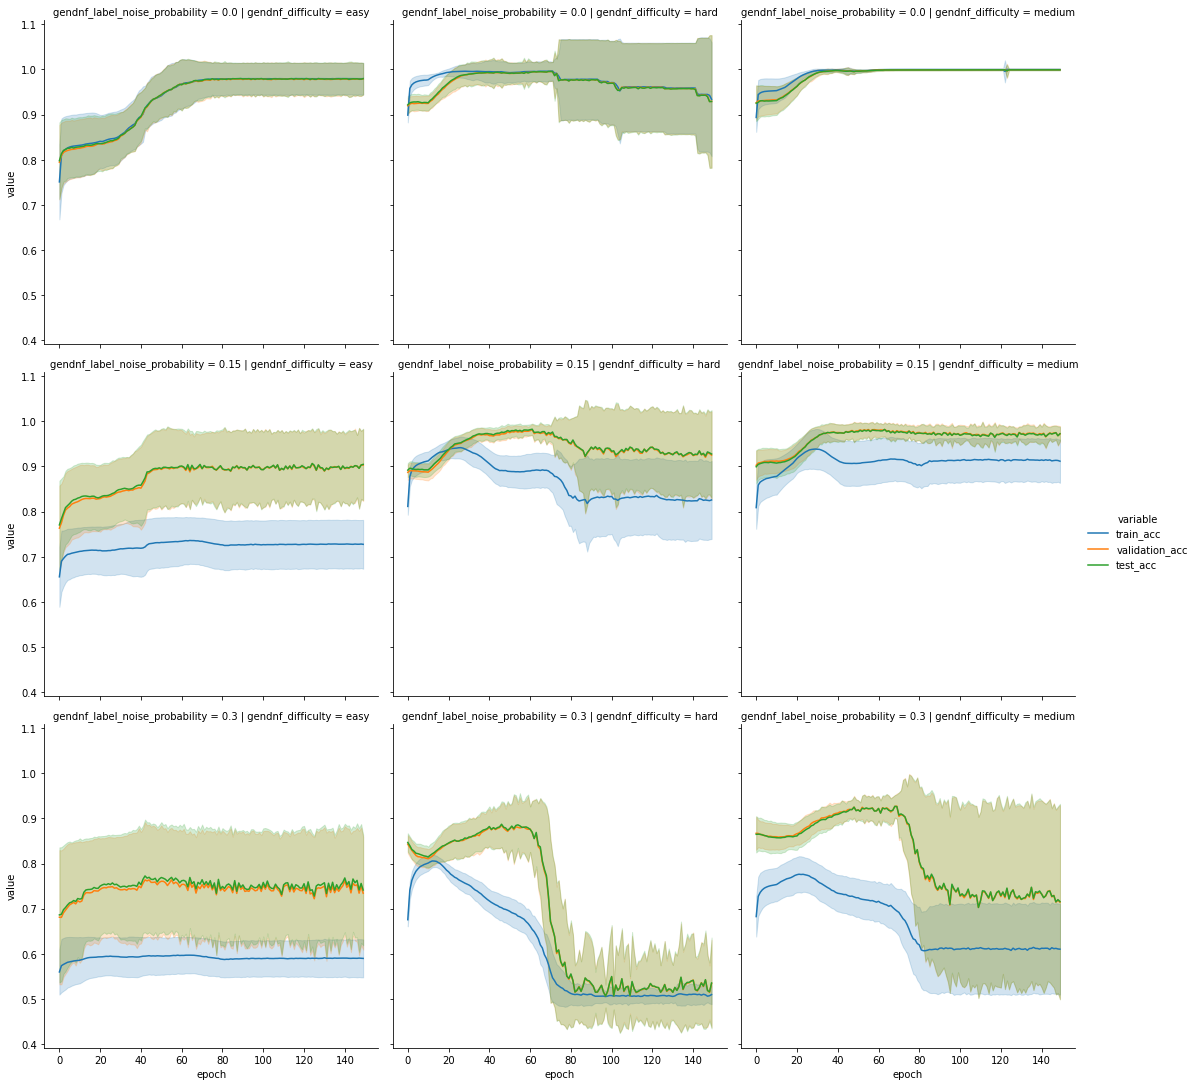

In [9]:
# Plot trainint and test results
df = exp_data
df = df[df['train_type'] == 'deep']
fields = [k for k in df.columns if k.endswith('loss')]
fields = [k for k in exp_data.columns if k.endswith('acc')]
df = df.melt(id_vars=['epoch', 'gendnf_difficulty', 'gendnf_label_noise_probability'], value_vars=fields)
sns.relplot(x='epoch', y='value', hue='variable', kind='line', col='gendnf_difficulty', row='gendnf_label_noise_probability', ci='sd', data=df)
# Plot accuracy
#fields = [k for k in exp_data.columns if k.endswith('acc')]
#plot_data = exp_data.melt(id_vars=['step'], value_vars=fields)
#sns.relplot(x='step', y='value', hue='variable', kind='line', data=plot_data)

In [10]:
# Collect the ILP comparison
ilp_exp_name = "gendnf-ilp-20210421-173228"
#experiment_name = exp_list[-1]
ilpexp = mlclient.get_experiment_by_name(ilp_exp_name)
print(ilpexp)
ilp_data =  utils.analysis.collect_experiment_data(ilp_exp_name, mlclient)
ilp_data.set_index('run_id', inplace=True)
fields = ['time', 'train_acc', 'validation_acc', 'test_acc', 'train_type', 'gendnf_difficulty', 'gendnf_rng_seed']
ilp_data = ilp_data[fields]
ilp_data = ilp_data.assign(timeout=ilp_data['time'] == 3600)
ilp_data.rename(columns={'train_type': 'model'}, inplace=True)
ilp_data

<Experiment: artifact_location='/homes/nuric/phd/pix2rule/data/artifacts/16', experiment_id='16', lifecycle_stage='active', name='gendnf-ilp-20210421-173228', tags={}>


,time,train_acc,validation_acc,test_acc,model,gendnf_difficulty,gendnf_rng_seed,timeout
run_id,,,,,,,,
604889ba72fd45cd9ef3029fbdc8112f,2585.000000,1.0,1.0,1.0,ilasp,easy,30,False
9a3f5e93bf934174acd3525a6975040e,36.730316,1.0,1.0,1.0,fastlas,easy,30,False
c1bc07e7a72749ca91dbd6c9a23169ca,29.968945,1.0,1.0,1.0,fastlas,easy,27,False
cd8aa82045f14944a2d410539e436f00,32.386715,1.0,1.0,1.0,fastlas,easy,21,False
05f329d23a0947249fd05ccc4ac65a9e,3600.000000,0.5,0.5,0.5,ilasp,easy,21,True
57d40b67fcbd44d1b3fcc082853c2315,30.991577,1.0,1.0,1.0,fastlas,easy,16,False
ab15a432b7734451a6e123b86bceed6e,42.863704,1.0,1.0,1.0,fastlas,easy,5,False
e07ec7f29f7449c99324314f6b07ea8f,1132.000000,1.0,1.0,1.0,ilasp,easy,16,False
80758f5ccf444623af4f466084bcb731,2166.000000,1.0,1.0,1.0,ilasp,easy,32,False


In [11]:
# Collect DRL model results
filtered_deep_data = best_runs[best_runs['gendnf_label_noise_probability'] == 0.0]
filtered_deep_data = filtered_deep_data[['gendnf_difficulty', 'gendnf_rng_seed', 'dnf_layer.or_kernel.test_preprune_acc', 'dnf_layer.and_kernel.test_threshold_pruned_acc']]
filtered_deep_data_preprune = filtered_deep_data[['gendnf_difficulty', 'gendnf_rng_seed', 'dnf_layer.or_kernel.test_preprune_acc']]
filtered_deep_data_preprune = filtered_deep_data_preprune.rename(columns={'dnf_layer.or_kernel.test_preprune_acc': 'test_acc'})
filtered_deep_data_preprune = filtered_deep_data_preprune.assign(model='DRL')
filtered_deep_data_threshold = filtered_deep_data[['gendnf_difficulty', 'gendnf_rng_seed', 'dnf_layer.and_kernel.test_threshold_pruned_acc']]
filtered_deep_data_threshold = filtered_deep_data_threshold.rename(columns={'dnf_layer.and_kernel.test_threshold_pruned_acc': 'test_acc'})
filtered_deep_data_threshold = filtered_deep_data_threshold.assign(model='DRLt')
concat_deep_data = pd.concat([filtered_deep_data_preprune, filtered_deep_data_threshold])
# Get total runtimes for these
run_times = exp_data[exp_data['run_id'].isin(concat_deep_data.index)].groupby(['run_id'])['time'].sum()
concat_deep_data = concat_deep_data.merge(run_times, left_index=True, right_index=True)
concat_deep_data.iloc[:10]

,gendnf_difficulty,gendnf_rng_seed,test_acc,model,time
run_id,,,,,
06279abc45914817b66852c13c8ae923,hard,32,1.000,DRL,459.848277
06279abc45914817b66852c13c8ae923,hard,32,0.985,DRLt,459.848277
0decd036a8cd471b86a4dd428f897047,easy,16,1.000,DRL,391.555976
0decd036a8cd471b86a4dd428f897047,easy,16,1.000,DRLt,391.555976
2190caa1cd2940a0b30690c8e465d6bf,easy,21,1.000,DRL,492.143455
2190caa1cd2940a0b30690c8e465d6bf,easy,21,0.992,DRLt,492.143455
24c7990e5b5d4a52b6cbbe0150223fb4,easy,30,1.000,DRL,399.750789
24c7990e5b5d4a52b6cbbe0150223fb4,easy,30,1.000,DRLt,399.750789
3b6fe1ee97db4596974ab958d245ea7b,hard,27,0.995,DRL,504.995338


In [12]:
# Merge the deep learning and ilp results into a table
filtered_ilp_data = ilp_data[ilp_data['timeout'] == False]
filtered_ilp_data = filtered_ilp_data[['time', 'test_acc', 'model', 'gendnf_difficulty', 'gendnf_rng_seed']]
filtered_ilp_data
concat_data = pd.concat([filtered_ilp_data, concat_deep_data])
pd.pivot_table(concat_data, index=['model'], columns=['gendnf_difficulty'], values=['test_acc', 'time'], aggfunc=['mean', 'std'])

mean                                               \
                   test_acc                             time               
gendnf_difficulty      easy      hard    medium         easy        hard   
model                                                                      
DRL                0.993714  0.999143  0.999429   484.779000  520.570468   
DRLt               0.986857  0.988143  0.991000   484.779000  520.570468   
fastlas            1.000000       NaN       NaN    33.701699         NaN   
ilasp              1.000000       NaN       NaN  2021.750000         NaN   

                                    std                                  \
                               test_acc                            time   
gendnf_difficulty      medium      easy      hard    medium        easy   
model                                                                     
DRL                538.858416  0.016630  0.001864  0.001512   88.307589   
DRLt               538.858416  0.027973  0.005178  0.002582   88.307589   
fastlas                   NaN  0.000000       NaN       NaN    4.673377   
ilasp                     NaN  0.000000       NaN       NaN  622.609763   

                                          
                                          
gendnf_difficulty        hard     medium  
model                                     
DRL                104.922657  80.542021  
DRLt               104.922657  80.542021  
fastlas                   NaN        NaN  
ilasp                     NaN        NaN

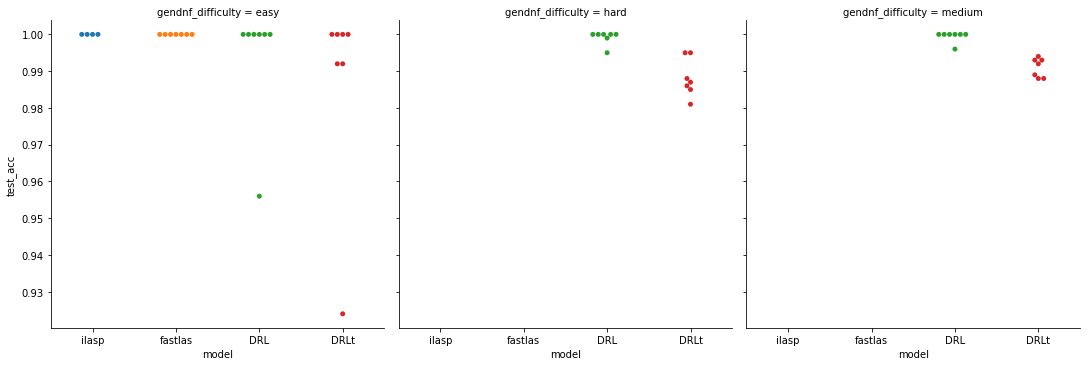

In [13]:
# Also as a plot
sns.catplot(x='model', y='test_acc', kind='swarm', col='gendnf_difficulty', data=concat_data)

## Analyse Run Report
We can pick a single run and analyse the reports such as attention maps and the rules it has learned.

- Look at learnt kernels, prepruning, after pruning and thresholded
- Show the final learnt rule

In [14]:
# For each difficulty pick a random run to analyse
gendnf_difficulty = "easy"
run_ids = best_runs[((best_runs['gendnf_difficulty'] == gendnf_difficulty) & (best_runs['gendnf_label_noise_probability'] == 0.0))].index
run_ids

Index(['755b505d12d2437c8d8d2750af9f3f1a', '7aa96d46c4ff42dc9d435415ca862b05',
       '0decd036a8cd471b86a4dd428f897047', '2190caa1cd2940a0b30690c8e465d6bf',
       '442255540cc347e4b3bcba08d95d11a5', '24c7990e5b5d4a52b6cbbe0150223fb4',
       '7dc2db381de645f58b7e225072d66bf4'],
      dtype='object', name='run_id')

In [15]:
# Gather a specific run
run_id = "6767afba57c1494c999d2abccca016d2"
run_id = run_ids[0]
print("Collecting artifacts for run:", run_id)
mlrun = mlclient.get_run(run_id)
pprint(mlrun.to_dictionary())
pprint(mlclient.list_artifacts(run_id))

{'data': {'metrics': {'epoch': 149.0,
                      'test_acc': 0.9559999704360962,
                      'test_loss': 0.11623819172382355,
                      'time': 3.3440890312194824,
                      'train_acc': 0.9588404893875122,
                      'train_dnf_layer/success_threshold': 6.0,
                      'train_loss': 0.11373695731163025,
                      'validation_acc': 0.9549999833106995,
                      'validation_loss': 0.11661121994256973},
          'params': {'config_json': 'data/experiments.json.0580b22744f67066c97715540c64af54',
                     'data_dir': 'data',
                     'dataset_name': 'gendnf',
                     'debug': 'False',
                     'dnf_image_classifier_hidden_arities': '[0]',
                     'dnf_image_classifier_hidden_layer_name': 'WeightedDNF',
                     'dnf_image_classifier_hidden_num_conjuncts': '8',
                     'dnf_image_classifier_hidden_num_total_variab

In [16]:
# Here is the model summary
print(utils.analysis.load_artifact(run_id, "model_summary.txt", mlclient))

Model: "dnf_rule_learner"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nullary (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
unary (InputLayer)              [(None, 3, 2)]       0                                            
__________________________________________________________________________________________________
binary (InputLayer)             [(None, 3, 2, 2)]    0                                            
__________________________________________________________________________________________________
merge_facts (MergeFacts)        {'nullary': (None, 2 0           nullary[0][0]                    
                                                                 unary[0][0]       

In [17]:
# What was the task?
task_description = utils.analysis.load_artifact(run_id, 'task_description.json', mlclient)
print("Target kernels:")
pprint(task_description['metadata']['and_kernel'])
pprint(task_description['metadata']['or_kernel'])
print("Target rule:")
task_description['metadata']['rule_str']

Target kernels:
('[[1, -1, -1, -1, -1, 1, 1, 0, -1, -1], [-1, 0, 0, 0, -1, -1, 1, 1, -1, -1], '
 '[0, 0, 1, 0, 0, 0, 0, 0, -1, 1]]')
'[1, 1, 1]'
Target rule:


['t :- nullary(0), not nullary(1), not unary(V0,0), not unary(V0,1), not unary(V1,0), unary(V1,1), binary(V0,V1,0), not binary(V1,V0,0), not binary(V1,V0,1), obj(V0), V0 != V1, obj(V1).',
 't :- not nullary(0), not unary(V1,0), not unary(V1,1), binary(V0,V1,0), binary(V0,V1,1), not binary(V1,V0,0), not binary(V1,V0,1), obj(V0), V0 != V1, obj(V1).',
 't :- unary(V0,0), not binary(V1,V0,0), binary(V1,V0,1), obj(V0), V0 != V1, obj(V1).']

In [18]:
# What did the model learn?
pruning_info = utils.analysis.load_artifact(run_id, 'pruning_info.json', mlclient)
for key in ['preprune', 'pruned', 'threshold_pruned']:
    print(key.upper())
    print(np.array(pruning_info["dnf_layer.or_kernel."+key]))
    print(np.array(pruning_info["dnf_layer.and_kernel."+key]))

PREPRUNE
[[0.72684 7.90653 7.62616]]
[[[ 0.09513 -0.08504 -1.82633 -0.09034 -3.9454   0.10313  3.93167  0.42168 -4.55213 -3.31336]
  [ 0.00302 -0.06195  0.78188 -0.07188 -0.0088   0.02514  0.01714 -0.0309  -4.13195  4.26181]
  [-0.55297 -0.06259 -0.68904 -1.75982  5.75043  0.21306 -4.33649  0.07373  0.58052  0.5909 ]]]
PRUNED
[[0.72684 7.90653 7.62616]]
[[[ 0.09513 -0.08504 -1.82633 -0.09034 -3.9454   0.10313  3.93167  0.42168 -4.55213 -3.31336]
  [ 0.      -0.       0.78188 -0.      -0.       0.       0.      -0.      -4.13195  4.26181]
  [-0.55297 -0.      -0.68904 -1.75982  5.75043  0.      -4.33649  0.       0.58052  0.5909 ]]]
THRESHOLD_PRUNED
[[6. 6. 6.]]
[[[ 0. -0. -6. -0. -6.  0.  6.  6. -6. -6.]
  [ 0.  0.  6.  0.  0.  0.  0.  0. -6.  6.]
  [-6.  0. -6. -6.  6.  0. -6.  0.  6.  6.]]]


In [19]:
# What is the final rule?
print("Final test accuracy with following rule is", pruning_info['dnf_layer.and_kernel.test_threshold_pruned_acc'])
test_report = utils.analysis.load_artifact(run_id, 'test_report.npz', mlclient)
# Here we construct an interpretation to get the size of the domain, it is not used in translating the actual rule
interpretation = {k: test_report['in_'+k] for k in ['nullary', 'unary', 'binary']}
rule_kernels = {
    'and_kernel': np.array(pruning_info['dnf_layer.and_kernel.threshold_pruned'])[0]/6,
    'or_kernel': np.array(pruning_info['dnf_layer.or_kernel.threshold_pruned'])[0]/6,
    'num_variables': task_description['metadata']['num_variables']
}
learnt_rules = utils.clingo.tensor_rule_to_strings(interpretation, rule_kernels)
learnt_rules

Final test accuracy with following rule is 0.9240000247955322


['t :- not unary(V0,0), not unary(V1,0), binary(V0,V1,0), binary(V0,V1,1), not binary(V1,V0,0), not binary(V1,V0,1), obj(V0), V0 != V1, obj(V1).',
 't :- unary(V0,0), not binary(V1,V0,0), binary(V1,V0,1), obj(V0), V0 != V1, obj(V1).',
 't :- not nullary(0), not unary(V0,0), not unary(V0,1), unary(V1,0), not binary(V0,V1,0), binary(V1,V0,0), binary(V1,V0,1), obj(V0), V0 != V1, obj(V1).']

In [20]:
# Sanity check with clingo, this is just a single batch check, the training script does the full version
results = utils.clingo.clingo_rule_check(interpretation, learnt_rules)
(results == (test_report['out_label'] == 1)).mean()

100%|██████████| 128/128 [00:02<00:00, 56.18it/s]


0.9375

In [21]:
{k: v for k, v in pruning_info.items() if 'acc' in k}

{'dnf_layer.or_kernel.validation_preprune_acc': 0.9549999833106995,
 'dnf_layer.or_kernel.test_preprune_acc': 0.9559999704360962,
 'dnf_layer.or_kernel.validation_pruned_acc': 0.9549999833106995,
 'dnf_layer.or_kernel.test_pruned_acc': 0.9559999704360962,
 'dnf_layer.or_kernel.validation_threshold_acc': 0.9419999718666077,
 'dnf_layer.or_kernel.test_threshold_acc': 0.9430000185966492,
 'dnf_layer.or_kernel.validation_threshold_pruned_acc': 0.9419999718666077,
 'dnf_layer.or_kernel.test_threshold_pruned_acc': 0.9430000185966492,
 'dnf_layer.and_kernel.validation_preprune_acc': 0.9419999718666077,
 'dnf_layer.and_kernel.test_preprune_acc': 0.9430000185966492,
 'dnf_layer.and_kernel.validation_pruned_acc': 0.9409999847412109,
 'dnf_layer.and_kernel.test_pruned_acc': 0.9409999847412109,
 'dnf_layer.and_kernel.validation_threshold_acc': 0.9160000085830688,
 'dnf_layer.and_kernel.test_threshold_acc': 0.9240000247955322,
 'dnf_layer.and_kernel.validation_threshold_pruned_acc': 0.9160000085830